<a href="https://colab.research.google.com/github/Cado87/RF-DETR-Play/blob/main/how-to-finetune-rf-detr-on-detection-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Tue Dec 23 06:40:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.2.1 or higher (which includes the new Nano, Small, and Medium checkpoints), along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [3]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create object detection datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled datasets for a range of use cases.

In [ ]:
#Download dataset from Github
# !wget -q https://github.com/Cado87/Fruit-dataset/archive/refs/heads/main.zip -O fruit-dataset.zip
# !unzip -q fruit-dataset.zip -d /content/
# !rm fruit-dataset.zip

# print("Dataset downloaded and extracted to /content/Fruit-dataset/")

Dataset downloaded and extracted to /content/Fruit-dataset/


In [5]:
#Download dataset from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Unzip folder from /content/drive/MyDrive/Datasets/Fruits/Fruit-dataset.zip
!unzip -q /content/drive/MyDrive/Datasets/Fruits/Fruit-dataset.zip -d /content/

In [7]:
from roboflow import download_dataset

# Define a simple class to mimic the dataset object structure
class MockDataset:
    def __init__(self, location):
        self.location = location

# Assign the fruit dataset location to the 'dataset' variable
dataset = MockDataset("/content/Dataset_2/")
print(f"Dataset location set to: {dataset.location}")

Dataset location set to: /content/Dataset_2/


In [8]:
import supervision as sv
import os

# Load the entire dataset from the COCO format files
full_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=dataset.location,
    annotations_path=os.path.join(dataset.location, "_annotations.coco.json")
)

# Print total dataset size
print(f"Total images in dataset: {len(full_dataset)}")

# Split the dataset into train, validation, and test sets
# First, split into train and a remaining part (20%)
ds_train, ds_remaining = full_dataset.split(split_ratio=0.8, shuffle=True)
# Then, split the remaining part (20%) into validation (10%) and test (10%)
ds_valid, ds_test = ds_remaining.split(split_ratio=0.5, shuffle=True)

print(f"Train set size: {len(ds_train)} images")
print(f"Validation set size: {len(ds_valid)} images")
print(f"Test set size: {len(ds_test)} images")

# Export the datasets to COCO JSON format
def export_dataset_to_coco(dataset_obj, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    dataset_obj.as_coco(annotations_path=os.path.join(output_dir, "_annotations.coco.json"), images_directory_path=output_dir)
    print(f"Exported {len(dataset_obj)} images to {output_dir}")

# Create subdirectories for train, valid, and test within dataset.location
train_output_dir = os.path.join(dataset.location, "train")
valid_output_dir = os.path.join(dataset.location, "valid")
test_output_dir = os.path.join(dataset.location, "test")

# Export each split
export_dataset_to_coco(ds_train, train_output_dir)
export_dataset_to_coco(ds_valid, valid_output_dir)
export_dataset_to_coco(ds_test, test_output_dir)


Total images in dataset: 49
Train set size: 39 images
Validation set size: 5 images
Test set size: 5 images
Exported 39 images to /content/Dataset_2/train
Exported 5 images to /content/Dataset_2/valid
Exported 5 images to /content/Dataset_2/test


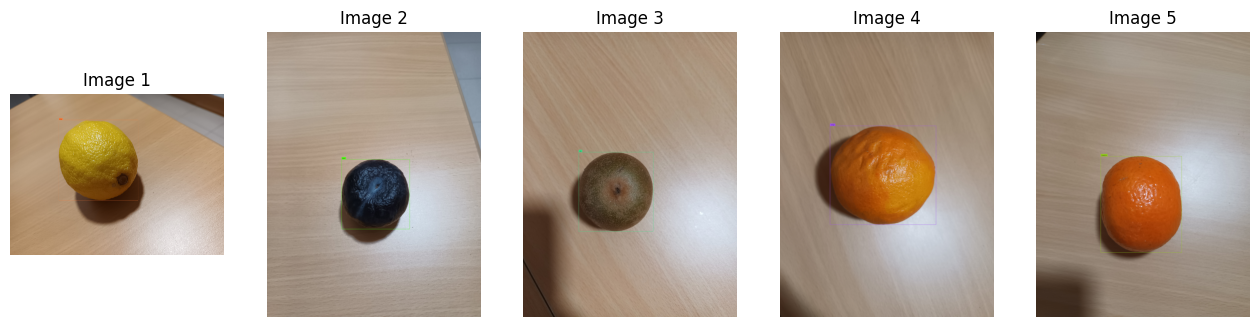

In [9]:
#Visualize labels

import supervision as sv
from PIL import Image, ImageOps
import random

# Get class names from the dataset for display
class_names = ds_train.classes

# Create annotators
bbox_annotator = sv.BoxAnnotator(color=sv.ColorPalette.DEFAULT, thickness=2)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.DEFAULT,
    text_color=sv.Color.BLACK,
    text_scale=0.5,
    text_thickness=1
)

# Select a few random images from the training set for visualization
num_images_to_display = 5
image_indices = random.sample(range(len(ds_train)), min(num_images_to_display, len(ds_train)))

annotated_images = []
for index in image_indices:
    path, image, annotations = ds_train[index]
    image = ImageOps.exif_transpose(Image.open(path).convert("RGB"))

    labels = [
        f"{class_names[class_id]}"
        for class_id
        in annotations.class_id
    ]

    # Annotate the image with bounding boxes and labels
    annotated_image = bbox_annotator.annotate(image.copy(), annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    annotated_images.append(annotated_image)

# Display the annotated images
if annotated_images:
    sv.plot_images_grid(
        images=annotated_images,
        titles=[f"Image {i+1}" for i in range(len(annotated_images))],
        grid_size=(1, len(annotated_images)), # Display all in one row
        size=(16, 8)
    )
else:
    print("No images to display from the training set.")

## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [10]:
from rfdetr import RFDETRNano

model = RFDETRNano()

model.train(dataset_dir=dataset.location, epochs=30, batch_size=4, grad_accum_steps=4)

rf-detr-nano.pth: 100%|██████████| 349M/349M [00:08<00:00, 41.8MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 13 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=13, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=30, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=2, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=

Epoch: [0]  [0/5]  eta: 0:01:28  lr: 0.000100  class_error: 90.60  loss: 8.7932 (8.7932)  loss_ce: 0.8504 (0.8504)  loss_bbox: 0.8893 (0.8893)  loss_giou: 1.0528 (1.0528)  loss_ce_0: 0.7995 (0.7995)  loss_bbox_0: 1.0733 (1.0733)  loss_giou_0: 1.1486 (1.1486)  loss_ce_enc: 0.7898 (0.7898)  loss_bbox_enc: 1.0267 (1.0267)  loss_giou_enc: 1.1627 (1.1627)  loss_ce_unscaled: 0.8504 (0.8504)  class_error_unscaled: 90.5983 (90.5983)  loss_bbox_unscaled: 0.1779 (0.1779)  loss_giou_unscaled: 0.5264 (0.5264)  cardinality_error_unscaled: 3863.0000 (3863.0000)  loss_ce_0_unscaled: 0.7995 (0.7995)  loss_bbox_0_unscaled: 0.2147 (0.2147)  loss_giou_0_unscaled: 0.5743 (0.5743)  cardinality_error_0_unscaled: 3881.2500 (3881.2500)  loss_ce_enc_unscaled: 0.7898 (0.7898)  loss_bbox_enc_unscaled: 0.2053 (0.2053)  loss_giou_enc_unscaled: 0.5814 (0.5814)  cardinality_error_enc_unscaled: 3041.7500 (3041.7500)  time: 17.7002  data: 6.2376  max mem: 2700
Epoch: [0]  [4/5]  eta: 0:00:04  lr: 0.000100  class_error

Test:  [0/2]  eta: 0:00:02  class_error: 75.00  loss: 6.8640 (6.8640)  loss_ce: 1.1875 (1.1875)  loss_bbox: 0.5788 (0.5788)  loss_giou: 0.4766 (0.4766)  loss_ce_0: 1.1875 (1.1875)  loss_bbox_0: 0.4855 (0.4855)  loss_giou_0: 0.4925 (0.4925)  loss_ce_enc: 1.1484 (1.1484)  loss_bbox_enc: 0.7220 (0.7220)  loss_giou_enc: 0.5851 (0.5851)  loss_ce_unscaled: 1.1875 (1.1875)  class_error_unscaled: 75.0000 (75.0000)  loss_bbox_unscaled: 0.1158 (0.1158)  loss_giou_unscaled: 0.2383 (0.2383)  cardinality_error_unscaled: 299.0000 (299.0000)  loss_ce_0_unscaled: 1.1875 (1.1875)  loss_bbox_0_unscaled: 0.0971 (0.0971)  loss_giou_0_unscaled: 0.2462 (0.2462)  cardinality_error_0_unscaled: 299.0000 (299.0000)  loss_ce_enc_unscaled: 1.1484 (1.1484)  loss_bbox_enc_unscaled: 0.1444 (0.1444)  loss_giou_enc_unscaled: 0.2925 (0.2925)  cardinality_error_enc_unscaled: 79.7500 (79.7500)  time: 1.2597  data: 1.0919  max mem: 2700
Test:  [1/2]  eta: 0:00:00  class_error: 100.00  loss: 6.8640 (7.9569)  loss_ce: 0.910

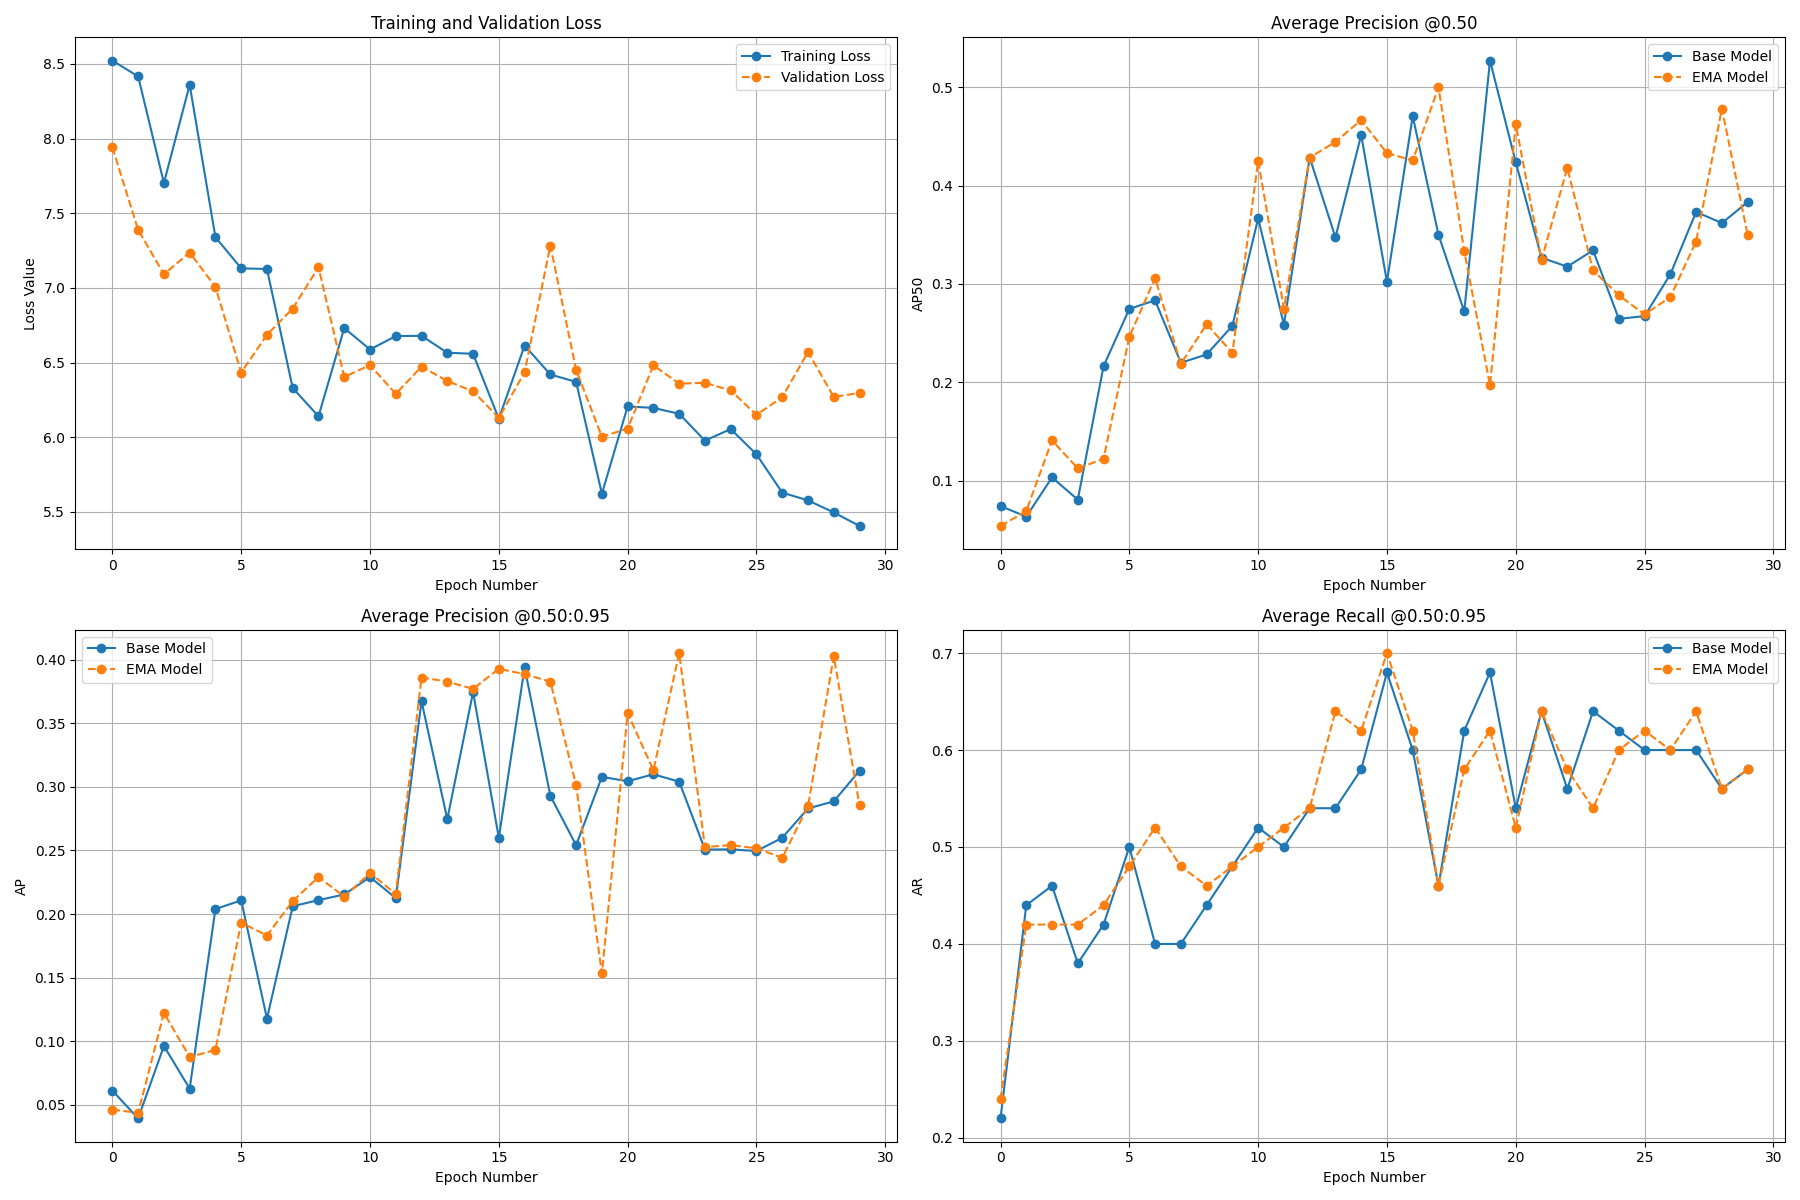

In [11]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [12]:
!ls -la /content/output

total 2717408
drwxr-xr-x 3 root root      4096 Dec 23 07:00 .
drwxr-xr-x 1 root root      4096 Dec 23 06:45 ..
-rw-r--r-- 1 root root 483843181 Dec 23 06:51 checkpoint0009.pth
-rw-r--r-- 1 root root 483843181 Dec 23 06:56 checkpoint0019.pth
-rw-r--r-- 1 root root 483843181 Dec 23 07:00 checkpoint0029.pth
-rw-r--r-- 1 root root 362914154 Dec 23 06:57 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 362921734 Dec 23 06:54 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 120941343 Dec 23 07:00 checkpoint_best_total.pth
-rw-r--r-- 1 root root 483833869 Dec 23 07:00 checkpoint.pth
drwxr-xr-x 2 root root      4096 Dec 23 06:46 eval
-rw-r--r-- 1 root root     13092 Dec 23 07:00 events.out.tfevents.1766472344.806392728dee.223.0
-rw-r--r-- 1 root root    161856 Dec 23 07:00 log.txt
-rw-r--r-- 1 root root    254139 Dec 23 07:00 metrics_plot.png
-rw-r--r-- 1 root root      1618 Dec 23 07:00 results.json


In [13]:
import os
from google.colab import files

output_dir = "/content/output/"
zip_file_name = "output.zip"

# Zip the directory
!zip -r "{zip_file_name}" "{output_dir}"

# Download the zipped file
files.download(zip_file_name)

  adding: content/output/ (stored 0%)
  adding: content/output/checkpoint_best_ema.pth (deflated 8%)
  adding: content/output/events.out.tfevents.1766472344.806392728dee.223.0 (deflated 70%)
  adding: content/output/eval/ (stored 0%)
  adding: content/output/eval/000.pth (deflated 99%)
  adding: content/output/eval/latest.pth (deflated 99%)
  adding: content/output/checkpoint.pth (deflated 8%)
  adding: content/output/metrics_plot.png (deflated 5%)
  adding: content/output/checkpoint0029.pth (deflated 8%)
  adding: content/output/checkpoint0019.pth (deflated 8%)
  adding: content/output/checkpoint0009.pth (deflated 8%)
  adding: content/output/checkpoint_best_total.pth (deflated 7%)
  adding: content/output/log.txt (deflated 83%)
  adding: content/output/results.json (deflated 78%)
  adding: content/output/checkpoint_best_regular.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [14]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [15]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 487.54 MB | Reserved: 4420.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 132.98 MB | Reserved: 370.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [18]:
model = RFDETRNano(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


reinitializing detection head with 12 classes


Loading pretrain weights


In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.002


## Run Inference with Fine-tuned RF-DETR Model

Number of detections: 0


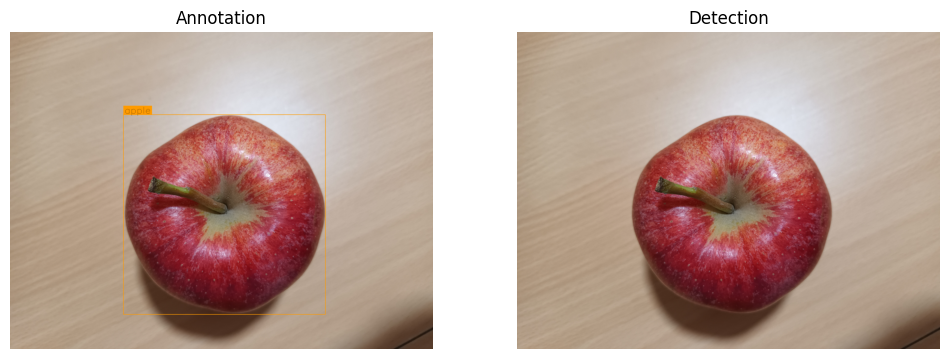

In [ ]:
import supervision as sv
from PIL import Image, ImageOps

path, image, annotations = ds[0]
image = ImageOps.exif_transpose(Image.open(path).convert("RGB"))

detections = model.predict(image, threshold=0.2)

print(f"Number of detections: {len(detections)}")
if len(detections) > 0:
    print(f"Detections confidence scores: {detections.confidence}")

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

det_labels = []
if len(detections) > 0:
    det_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, det_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>